In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import pandas as pd

In [17]:
base_model_path = "/model-weights/Llama-3.2-1B"
lora_model_path = "/h/emzed/tests/finetuning/llama2-qa-lora/checkpoint-1126"

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    device_map="auto",
)

# Load the LoRA model
model1 = PeftModel.from_pretrained(base_model, lora_model_path)
model1.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in

In [18]:
lora_model_path2 = "/h/emzed/tests/finetuning/emziiiii-llama2-qa-lora/checkpoint-1126"
model2 = PeftModel.from_pretrained(base_model, lora_model_path2)
model2.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in

In [19]:
def generate_response(model, text, max_length=512):
    # Format the prompt
    prompt = f"### Text:\n{text}\n### Question:\n"
    
    # Tokenize input
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_length)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=True,
            temperature=0.7,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove the input prompt from the response
    response = response[len(prompt):].strip()
    return response

In [34]:
df = pd.read_csv('/h/emzed/data/qa_discharge_masked.csv')
# valid_rows = df[df['masked_text'].str.len() < 1500]
test_cases = df.sample(n=1)

for i, row in test_cases.iterrows():
    print(f"Test Case {i+1}:")
    response1 = generate_response(model1, row['masked_text'][:1500])
    response2 = generate_response(model2, row['masked_text'][:1500])
    print(f"Gold Question: {row['q']}")
    print(f"Q1: {response1}\n")
    print(f"Q2: {response2}\n")



Test Case 638:
Gold Question: What was the patient's treatment for alcohol withdrawal in the ICU?
Q1: What is the most likely diagnosis?
2. What is the most likely etiology?
3. What is the most likely outcome?
4. What is the best method for preventing re-hospitalization?
5. What is this patient's prognosis? 
6. What is his current status? 

 
Discharge

Q2: What is the best way to manage this patient with 
significant drug and alcohol use disorder? 2. What is the best way to manage this patient with 
significant drug and alcohol use disorder? 3. What is the best way to manage this patient with 
significant drug and alcohol use disorder? 4



In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import nltk
nltk.download('punkt')

In [133]:
def evaluate_responses(df, num_samples=100):
    # Initialize scorers
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoother = SmoothingFunction()
    
    # Sample test cases
    test_cases = df.sample(n=num_samples, random_state=42)
    
    # Initialize score lists
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for i, row in test_cases.iterrows():
        # Generate model response
        model_response = generate_response(row['masked_text'][:1500])
        reference = row['q']
        
        # Calculate BLEU score
        # Tokenize reference and hypothesis
        reference_tokens = nltk.word_tokenize(reference.lower())
        hypothesis_tokens = nltk.word_tokenize(model_response.lower())
        
        # Calculate BLEU score with smoothing
        bleu = sentence_bleu([reference_tokens], hypothesis_tokens, 
                           smoothing_function=smoother.method1)
        bleu_scores.append(bleu)
        
        # Calculate ROUGE scores
        rouge_scores = rouge.score(reference, model_response)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)
    
    # Calculate average scores
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    
    print(f"Evaluation Results (over {num_samples} samples):")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
    print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}")
    print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")
    
    return {
        'bleu': avg_bleu,
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    }

# Run evaluation
results = evaluate_responses(df, num_samples=100)


[nltk_data] Downloading package punkt to /h/emzed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Evaluation Results (over 100 samples):
Average BLEU Score: 0.0080
Average ROUGE-1 Score: 0.1228
Average ROUGE-2 Score: 0.0160
Average ROUGE-L Score: 0.1103


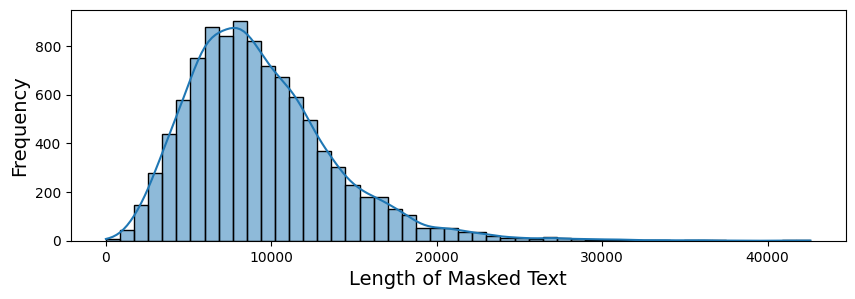

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate lengths of masked text
text_lengths = df['masked_text'].str.len()

# Create distribution plot
plt.figure(figsize=(10, 3))
sns.histplot(text_lengths, bins=50, kde=True)
# plt.title('Distribution of Masked Text Lengths')
plt.xlabel('Length of Masked Text', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()
